<a href="https://colab.research.google.com/github/RawanKhaled20/Unsupervised_Seeds_Clustering/blob/main/Unsupervised_learning_using_cfuzzy_and_cfuzzyentropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing dataset of wheat seeds**

In [1]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d jmcaro/wheat-seedsuci

  0% 0.00/3.60k [00:00<?, ?B/s]
100% 3.60k/3.60k [00:00<00:00, 8.40MB/s]


In [6]:
! unzip wheat-seedsuci.zip

Archive:  wheat-seedsuci.zip
  inflating: seeds.csv               


In [8]:
!pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894077 sha256=fdd4349a21d015cc7cb7668e722214459a1d884622e0741fb07eca2b7e4d9c22
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


**Import necessary libraries**

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix
from scipy.special import comb
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import skfuzzy as fuzz
from sklearn.metrics import silhouette_score
# Import Fuzzy C-means (FCM)
from skfuzzy.cluster import cmeans ,cmeans_predict
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial import distance_matrix
from itertools import combinations
from scipy.spatial.distance import cdist

# **Data Preprocessing**

In [13]:
import pandas as pd

df=pd.read_csv('seeds.csv')
print(df.shape)

(199, 8)


In [14]:
df.info()   # No nan values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             199 non-null    float64
 1   Perimeter        199 non-null    float64
 2   Compactness      199 non-null    float64
 3   Kernel.Length    199 non-null    float64
 4   Kernel.Width     199 non-null    float64
 5   Asymmetry.Coeff  199 non-null    float64
 6   Kernel.Groove    199 non-null    float64
 7   Type             199 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


In [18]:
df.head()   # No categorical values

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


**Detect outliers using distplot and boxplot visualization**

<ipython-input-20-b1b84311ed37>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)
<ipython-input-20-b1b84311ed37>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True)
<ipython-input-20-b1b84311ed37>:5: UserWarning: 

`distplot` is a deprecated function and will b

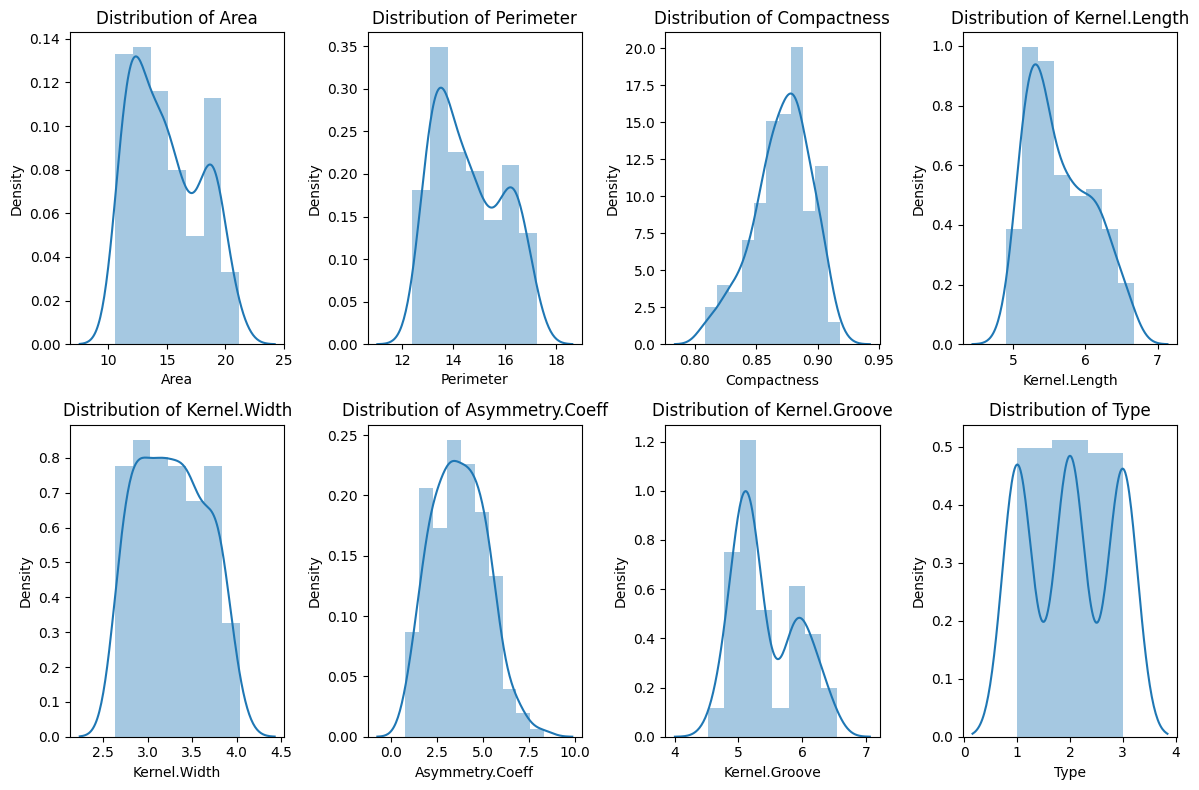

In [20]:
# Visualize distribution of each feature with distplots
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.columns):
    plt.subplot(2, 4, i+1)
    sns.distplot(df[col], kde=True)   # Mostly gaussian distribution
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

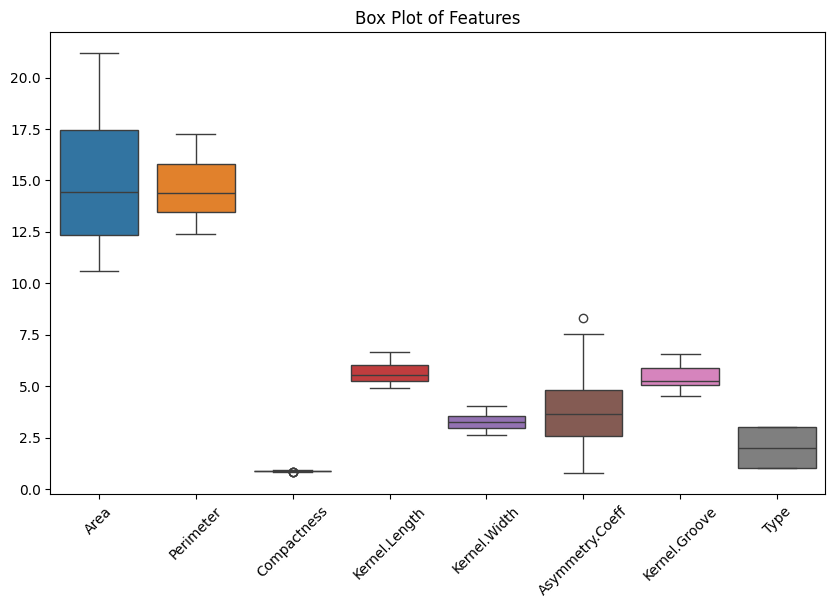

In [21]:
# Visualize outliers with box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title('Box Plot of Features')
plt.xticks(rotation=45)
plt.show()

Almost no outliers found

# **Correlation heatmap visualization**
 Get the correlation matrix to see the correlation between the features so that highly correlated features are redundant and understand the importance of applying PCA in that case

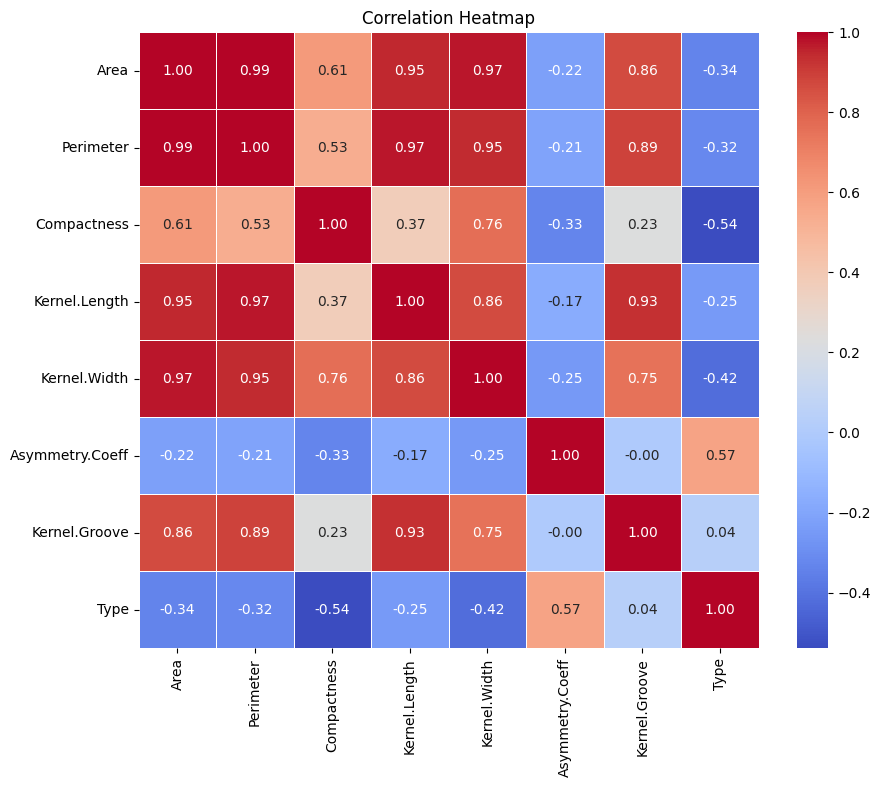

In [27]:
# Calculate correlation matrix for reduntant features removal
corr_matrix = df.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Alot of features are very higly correlated

**Remove the target column**

In [26]:
df_new = df.drop(columns=['Type'])

# **Applying PCA**
Using elbow method to get best component

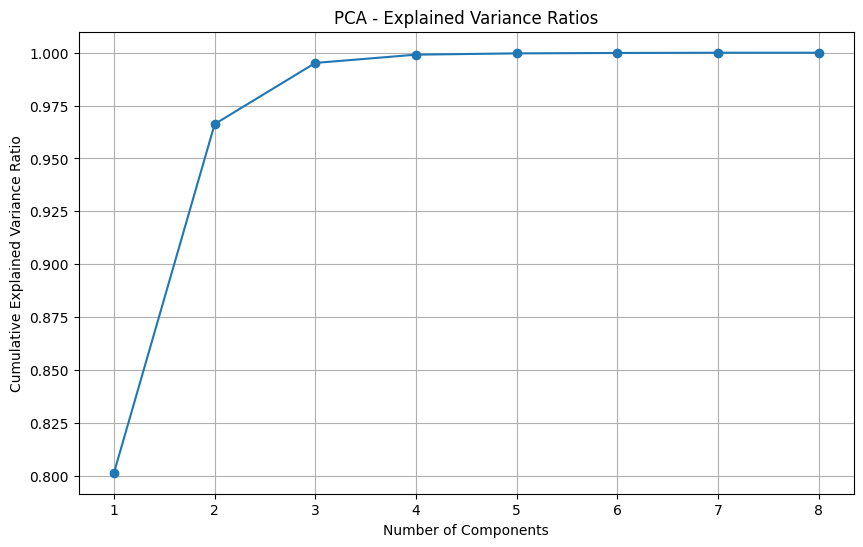

In [28]:
# Convert df to numpy array
X = df.values

# Create a list to store explained variance ratios
explained_variance_ratios = []

# Try different numbers of components
for n_components in range(1, min(df.shape)+1):
    # Initialize PCA with the current number of components
    pca = PCA(n_components=n_components)

    # Fit PCA to the data
    pca.fit(X)

    # Compute cumulative explained variance ratio
    explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

    # Store the cumulative explained variance ratio for the current number of components
    explained_variance_ratios.append(explained_variance_ratio_cumulative[-1])

# Plot explained variance ratios
plt.figure(figsize=(10, 6))
plt.plot(range(1, min(df.shape)+1), explained_variance_ratios, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA - Explained Variance Ratios')
plt.grid(True)
plt.show()

Using elbow method: As seen 4 is the best number of components as increasing more doesn't affect the explained variance in the data.

Using Compression and decompression of data

Number of Components: 1, Reconstruction Error: 0.3371902776708093


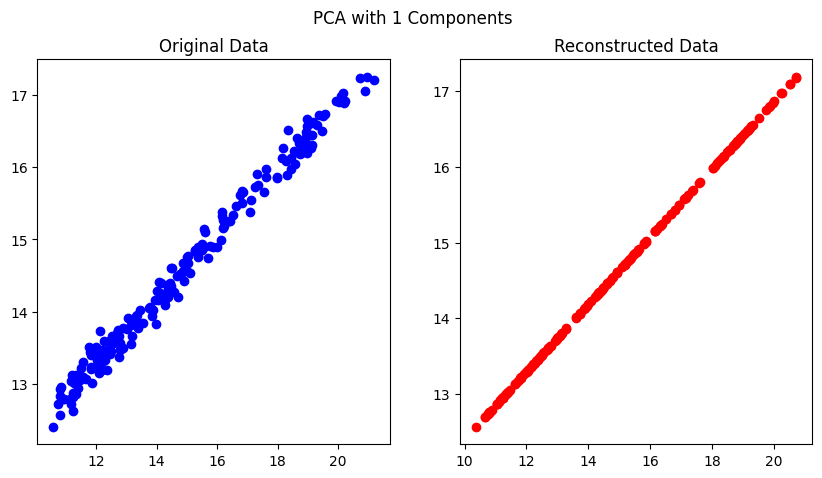

Number of Components: 2, Reconstruction Error: 0.05730003703443767


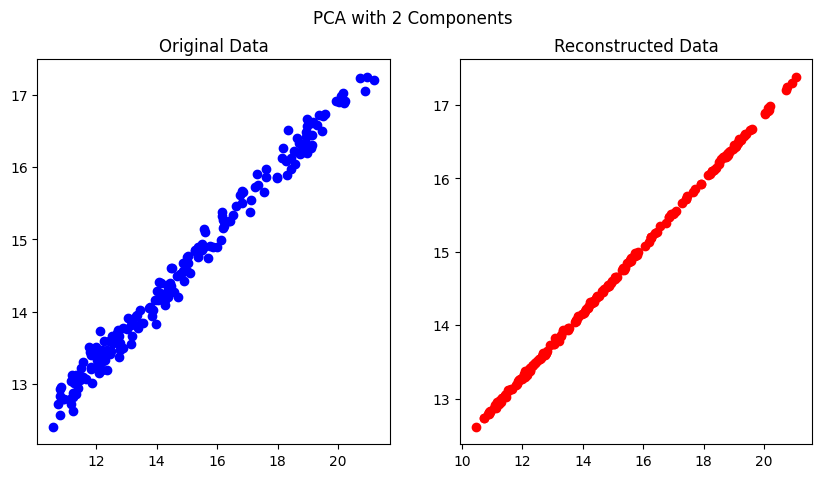

Number of Components: 3, Reconstruction Error: 0.008194740485392454


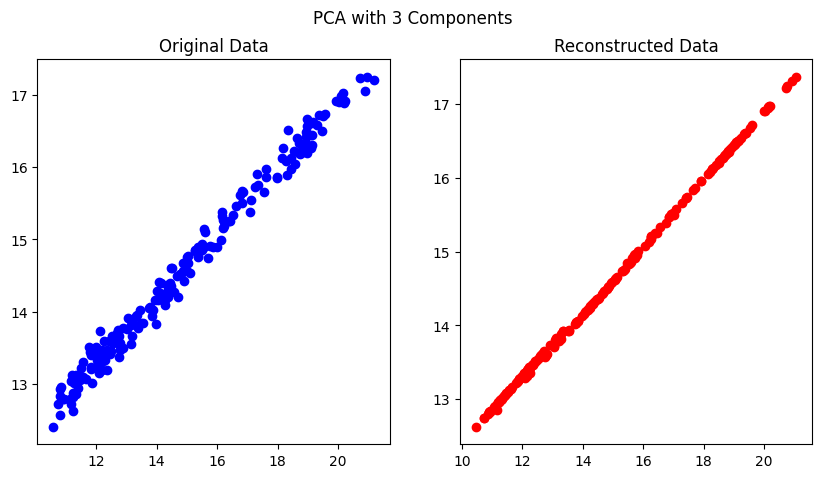

Number of Components: 4, Reconstruction Error: 0.0015706441163685358


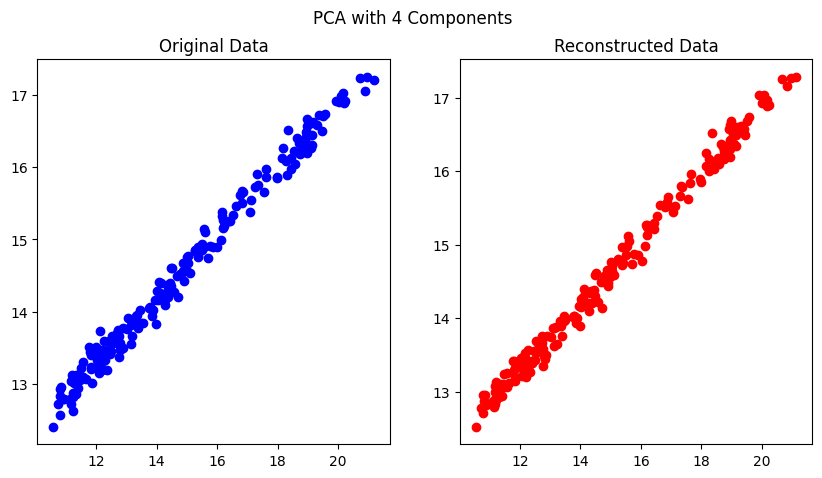

Number of Components: 5, Reconstruction Error: 0.0005208772523574893


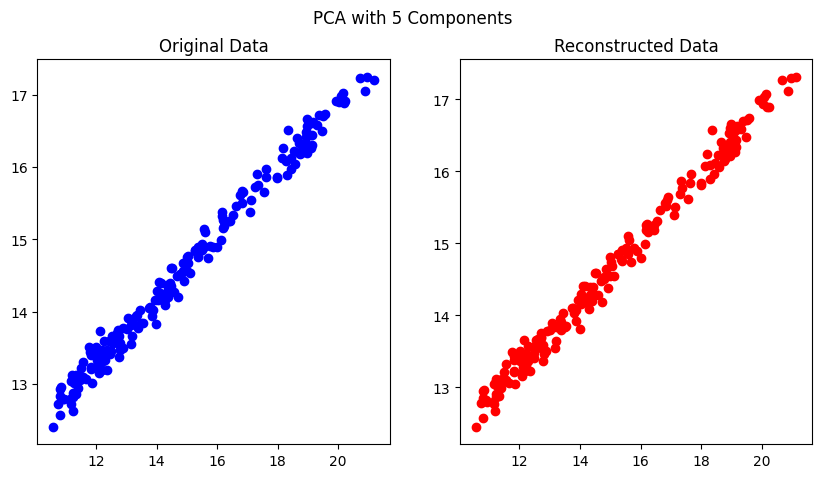

Number of Components: 6, Reconstruction Error: 0.00018745490107951283


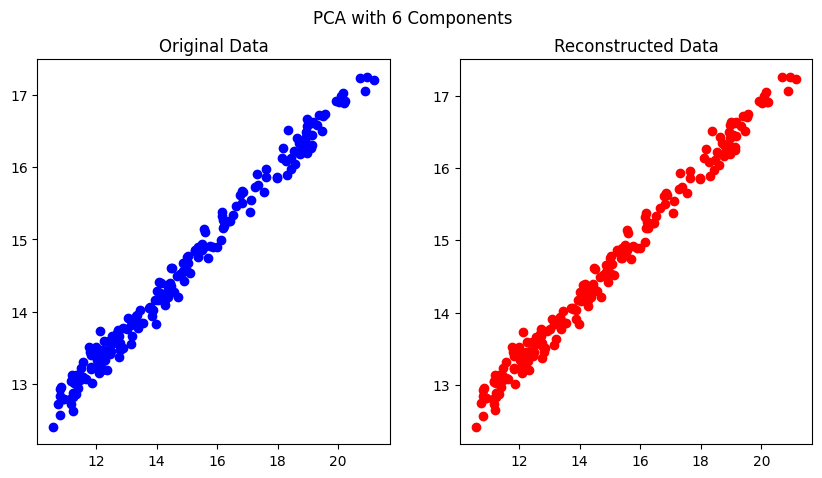

Number of Components: 7, Reconstruction Error: 3.0545228283404225e-06


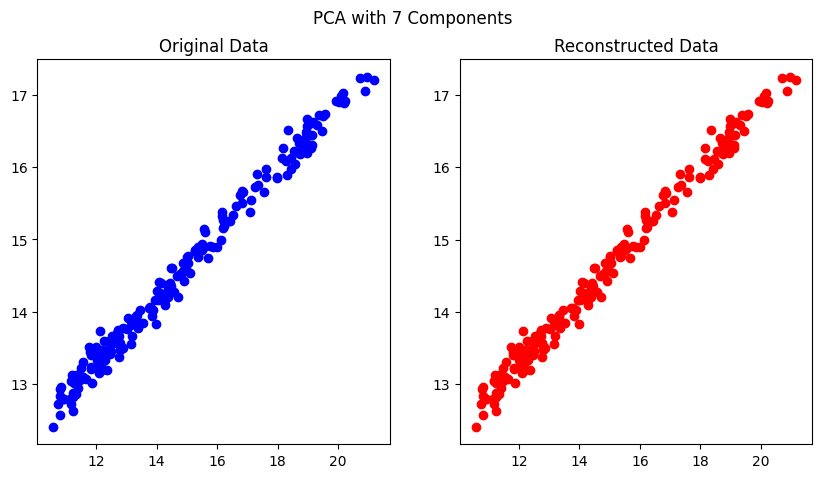

Number of Components: 8, Reconstruction Error: 3.7618928296637996e-31


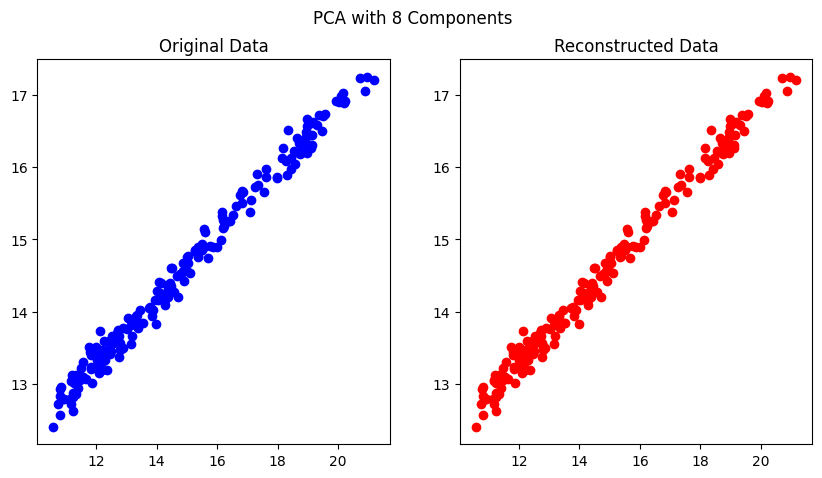

In [29]:
# Try different numbers of components
for n_components in range(1, min(df.shape)+1):
    # Initialize PCA with the current number of components
    pca = PCA(n_components=n_components)

    # Fit PCA to the data
    pca.fit(X)

    # Compress the data
    X_compressed = pca.transform(X)

    # Decompress the data
    X_decompressed = pca.inverse_transform(X_compressed)

    # Compute reconstruction error
    reconstruction_error = np.mean(np.square(X - X_decompressed))

    print(f"Number of Components: {n_components}, Reconstruction Error: {reconstruction_error}")

    # Plot the original and reconstructed data for visualization
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].scatter(X[:, 0], X[:, 1], c='b', label='Original Data')
    axes[0].set_title('Original Data')
    axes[1].scatter(X_decompressed[:, 0], X_decompressed[:, 1], c='r', label='Reconstructed Data')
    axes[1].set_title('Reconstructed Data')
    plt.suptitle(f'PCA with {n_components} Components')
    plt.show()

Using Construction/Deconstruction: As seen the error is decresing as we increase the number of components yet still at component 4 the data reconstructed starts to become very similar to the original yet will try capturing the point where the error doesn't change alot to be our optimal

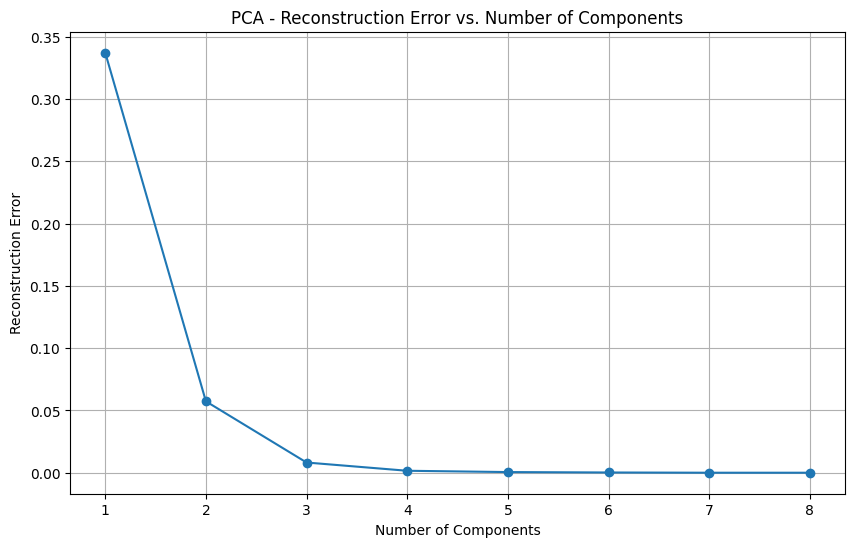

In [30]:
# Calculate reconstruction errors for different numbers of components to see where the error signifiacntly doesn't change
reconstruction_errors = []
for n_components in range(1, min(df.shape)+1):
    pca = PCA(n_components=n_components)
    pca.fit(X)
    X_decompressed = pca.inverse_transform(pca.transform(X))
    reconstruction_error = np.mean(np.square(X - X_decompressed))
    reconstruction_errors.append(reconstruction_error)

# Plot reconstruction errors
plt.figure(figsize=(10, 6))
plt.plot(range(1, min(df.shape)+1), reconstruction_errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('PCA - Reconstruction Error vs. Number of Components')
plt.grid(True)
plt.show()

As seen after plotting the reconstruction error we found that starting from 5 components it becomes very hard to distinguish the error so we will stick to 5 components as our optimal choice

In [31]:
# Initialize PCA with 5 components for traget less dataset
pca = PCA(n_components=5)

# Fit PCA to the data
pca.fit(df_new)

# Transform the original data to obtain the compressed representation
df_compressed = pca.transform(df_new)

# **1. Fuzzy C-Means (FCM):**
FCM is a soft clustering algorithm where each data point belongs to every cluster with a certain degree of membership.

**Key Hyperparameters:**

**n_clusters:** Number of clusters to partition the data into.

**m:** Fuzziness parameter that controls the degree of fuzziness in cluster assignments. It determines the level of cluster overlap; higher values of m lead to fuzzier clusters.

**error:** Convergence criterion based on the maximum change in cluster centers.

**maxiter:** Maximum number of iterations.
# **2. Entropy-Based Fuzzy Clustering:**
Entropy-based fuzzy clustering aims to minimize the entropy of cluster memberships, leading to well-separated clusters with clear boundaries.

**Key Hyperparameters:**

**n_clusters:** Number of clusters to partition the data into.

**beta:** Fuzziness parameter, similar to FCM.

**entropy:** Weighting parameter that controls the influence of entropy in the objective function. It balances the trade-off between minimizing entropy and maximizing cluster separation.

**lambda (λ):** typically corresponds to the width of the Gaussian function used to determine the degree of influence of data points on cluster memberships.

Now, let's apply both FCM on the original dataset, the pca applied dataset and a removed correlation dataset with different hyperparameter values:

In [34]:
# Define hyperparameter values to experiment with
n_clusters = 3
m_values = [1.1, 1.5, 2]  # Fuzziness parameter

# Perform Fuzzy C-Means (FCM)
for m in m_values:
    cntr_fcm, u_fcm, _, _, _, _, _ = cmeans(df_compressed.T, n_clusters, m, error=0.005, maxiter=1000)

    # Evaluate clustering performance
    silhouette_fcm = silhouette_score(df_compressed, np.argmax(u_fcm, axis=0))
    print(f"FCM (m={m}): Silhouette Score = {silhouette_fcm:.4f}")

FCM (m=1.1): Silhouette Score = 0.4729
FCM (m=1.5): Silhouette Score = 0.4729
FCM (m=2): Silhouette Score = 0.4729


In [35]:
# Define hyperparameter values to experiment with
n_clusters = 3
m_values = [1.1, 1.5, 2]  # Fuzziness parameter

# Perform Fuzzy C-Means (FCM)
for m in m_values:
    cntr_fcm, u_fcm, _, _, _, _, _ = cmeans(df_new.T, n_clusters, m, error=0.005, maxiter=1000)

    # Evaluate clustering performance
    silhouette_fcm = silhouette_score(df_new, np.argmax(u_fcm, axis=0))
    print(f"FCM (m={m}): Silhouette Score = {silhouette_fcm:.4f}")

FCM (m=1.1): Silhouette Score = 0.4727
FCM (m=1.5): Silhouette Score = 0.4727
FCM (m=2): Silhouette Score = 0.4727


In [39]:
#Remove highly correlated features as they are redundant
# Drop 'perimeter', 'kernel length', and 'kernel width' columns
df_new2 = df_new.drop(['Perimeter', 'Kernel.Length', 'Kernel.Width'], axis=1)

In [40]:
# Define hyperparameter values to experiment with
n_clusters = 3
m_values = [1.1, 1.5, 2]  # Fuzziness parameter

# Perform Fuzzy C-Means (FCM)
for m in m_values:
    cntr_fcm, u_fcm, _, _, _, _, _ = cmeans(df_new2.T, n_clusters, m, error=0.005, maxiter=1000)

    # Evaluate clustering performance
    silhouette_fcm = silhouette_score(df_new2, np.argmax(u_fcm, axis=0))
    print(f"FCM (m={m}): Silhouette Score = {silhouette_fcm:.4f}")

FCM (m=1.1): Silhouette Score = 0.4689
FCM (m=1.5): Silhouette Score = 0.4689
FCM (m=2): Silhouette Score = 0.4689


As seen The m value doesn't affect the Silhouette Score, yet regarding the datasets, the one with pca applied happens to have the best Silhouette Score

**NOW lets do the same with Entropy_based_fuzzy_clustering**

I couldn't find a library so i searched for a code that performs this clustering method

Reference: https://www.kaggle.com/code/mohammadartan/entropy-based-fuzzy-clustering

In [80]:
def calc_alpha(data, beta):
    return - np.log(beta) / (np.sum(distance_matrix(data, data)[np.triu_indices_from(distance_matrix(data, data))])/comb(data.shape[0],2))

In [81]:
def calc_similarity(data, alpha):
    similarities = []
    for d in cdist(data, data):
        similarities.append(np.exp(-alpha * d))
    return np.array(similarities)

In [82]:
def calc_entropies(similarities):
    entropies = {}
    for col in range(similarities.shape[1]):
        inner_entropy = []
        for sim in similarities[:, col]:
            if sim == 1:
                continue
            inner_entropy.append(sim * np.log2(sim) + (1 - sim) * np.log2(1 - sim))
        entropies[col] = (-np.sum(inner_entropy))
    entropies = {k: v for k, v in sorted(entropies.items(), key=lambda item: item[1])}
    return entropies

In [93]:
def entropy_based_fuzzy_clustering(data, beta, lamda):
    alpha = calc_alpha(data, beta)
    similarities = calc_similarity(data, alpha)
    entropies = calc_entropies(similarities)

    # Choose the number of clusters based on the number of entropies
    n_clusters = len(entropies)
    memberships = np.random.rand(data.shape[0], n_clusters)
    memberships /= np.sum(memberships, axis=1)[:, np.newaxis]  # Normalize memberships

    for _ in range(100):  # Maximum iterations
        centroids = np.dot(memberships.T, data) / np.sum(memberships, axis=0)[:, np.newaxis]
        distances = cdist(data, centroids)
        memberships = 1 / (1 + (distances / lamda) ** 2)
        memberships **= (1 / (beta - 1))
        memberships /= np.sum(memberships, axis=1)[:, np.newaxis]  # Normalize memberships

    # Assign cluster labels based on the highest membership values
    cluster_labels = np.argmax(memberships, axis=1)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(data, cluster_labels)

    return silhouette_avg

In [86]:
entropy_silhouette_score = entropy_based_fuzzy_clustering(df_new, beta=1.1, lamda=0.1)
print("Silhouette Score:", entropy_silhouette_score)

<ipython-input-82-f70bedb62b5d>:8: RuntimeWarning: invalid value encountered in log2
  inner_entropy.append(sim * np.log2(sim) + (1 - sim) * np.log2(1 - sim))


Silhouette Score: 0.11084949880388295


In [87]:
entropy_silhouette_score = entropy_based_fuzzy_clustering(df_new, beta=1.5, lamda=0.5)
print("Silhouette Score:", entropy_silhouette_score)

<ipython-input-82-f70bedb62b5d>:8: RuntimeWarning: invalid value encountered in log2
  inner_entropy.append(sim * np.log2(sim) + (1 - sim) * np.log2(1 - sim))


Silhouette Score: 0.14225842332027866


In [90]:
entropy_silhouette_score = entropy_based_fuzzy_clustering(df_new, beta=1.5, lamda=0.1)
print("Silhouette Score:", entropy_silhouette_score)

<ipython-input-82-f70bedb62b5d>:8: RuntimeWarning: invalid value encountered in log2
  inner_entropy.append(sim * np.log2(sim) + (1 - sim) * np.log2(1 - sim))


Silhouette Score: 0.05428757734100261


In [94]:
entropy_silhouette_score = entropy_based_fuzzy_clustering(df_new2, beta=1.5, lamda=0.5)
print("Silhouette Score:", entropy_silhouette_score)

<ipython-input-82-f70bedb62b5d>:8: RuntimeWarning: invalid value encountered in log2
  inner_entropy.append(sim * np.log2(sim) + (1 - sim) * np.log2(1 - sim))


Silhouette Score: 0.18139120306068776


In [92]:
entropy_silhouette_score = entropy_based_fuzzy_clustering(df_compressed, beta=1.5, lamda=0.5)
print("Silhouette Score:", entropy_silhouette_score)

<ipython-input-82-f70bedb62b5d>:8: RuntimeWarning: invalid value encountered in log2
  inner_entropy.append(sim * np.log2(sim) + (1 - sim) * np.log2(1 - sim))


Silhouette Score: 0.14965671830153002


I am not sure if this is how this clustring method should work but it perfroms 5 clusters instead of 3 which is the real number of clusters

# **Bouns: K_Means and Hierarchical Clustering**

In [95]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

# Step 1: Standard Scaling
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_new)

# Step 2: Hierarchical Clustering
n_clusters = 3  # Choose the number of clusters
hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labelsH = hierarchical_clustering.fit_predict(data_scaled)
# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labelsK = kmeans.fit_predict(data_scaled)

# Calculate silhouette score Hierarchical
silhouette_avg = silhouette_score(data_scaled, cluster_labelsH)
print("Silhouette Score (Hierarchical Clustering with Standard Scaling):", silhouette_avg)
# Calculate silhouette score K-means
silhouette_avg = silhouette_score(data_scaled, cluster_labelsK)
print("Silhouette Score (K_Means Clustering with Standard Scaling):", silhouette_avg)

Silhouette Score (Hierarchical Clustering with Standard Scaling): 0.39620888791074194
Silhouette Score (K_Means Clustering with Standard Scaling): 0.4043845826686474


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**Lastly, Get the F1_score, precision, recall and confusion matrix**

Precision: 0.04708324229844877
Recall: 0.05025125628140704
F1-score: 0.04861343755816118
Confusion Matrix:
 [[ 3  2 61]
 [66  0  2]
 [ 0 58  7]]


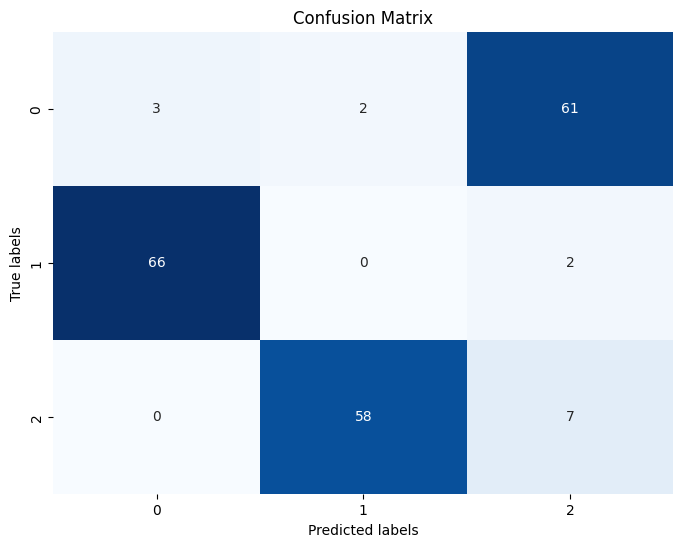

In [107]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Remove Labels
X_unlabeled = data_scaled.copy()  # Copy the standardized dataset without labels
# Replace all occurrences of 1 with 0, 2 with 1, and 3 with 2
df['Type'].replace({1: 0, 2: 1, 3: 2}, inplace=True)
y_true = df['Type']  # True labels

# Step 3: Evaluate Clustering Performance
precision = precision_score(y_true, cluster_labelsK, average='weighted')
recall = recall_score(y_true, cluster_labelsK, average='weighted')
f1 = f1_score(y_true, cluster_labelsK, average='weighted')
conf_matrix = confusion_matrix(y_true, cluster_labelsK)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [108]:
from sklearn.metrics import silhouette_score
import numpy as np
from skfuzzy.cluster import cmeans

# Define hyperparameter values to experiment with
n_clusters = 3
m_values = 1.1  # Fuzziness parameter

cntr_fcm, u_fcm, _, _, _, _, _ = cmeans(df_compressed.T, n_clusters, m, error=0.005, maxiter=1000)
cluster_labelsF = np.argmax(u_fcm, axis=0)

Precision: 0.3417693775677725
Recall: 0.37185929648241206
F1-score: 0.35600106895268835
Confusion Matrix:
 [[ 1 57  8]
 [59  9  0]
 [ 0  1 64]]


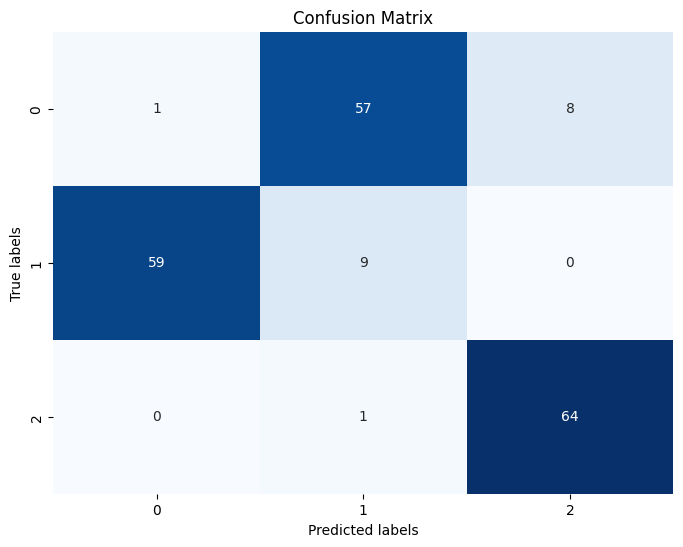

In [109]:
# Step 3: Evaluate Clustering Performance
precision = precision_score(y_true, cluster_labelsF, average='weighted')
recall = recall_score(y_true, cluster_labelsF, average='weighted')
f1 = f1_score(y_true, cluster_labelsF, average='weighted')
conf_matrix = confusion_matrix(y_true, cluster_labelsF)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

**I found another way for the entropy based fuzzy clustering**

In [137]:
# Define hyperparameter values to experiment with
n_clusters = 3
m_values = [1.1, 1.5, 2]  # Fuzziness parameter

# Perform Fuzzy C-Means (FCM) with entropy regularization
for m in m_values:
    # Run FCM clustering
    cntr, u, _, _, _, _, _ = cmeans(data=df_new2.T, c=n_clusters, m=m, error=1e-5, maxiter=1000)

    # Calculate entropy
    entropy = -np.sum(u * np.log(u))

    # Evaluate clustering performance
    silhouette_fcm = silhouette_score(df_new2, np.argmax(u, axis=0))
    print(f"FCM with Entropy Regularization (m={m}): Silhouette Score = {silhouette_fcm:.4f}, Entropy = {entropy:.4f}")

FCM with Entropy Regularization (m=1.1): Silhouette Score = 0.4689, Entropy = 4.9476
FCM with Entropy Regularization (m=1.5): Silhouette Score = 0.4689, Entropy = 42.6023
FCM with Entropy Regularization (m=2): Silhouette Score = 0.4689, Entropy = 100.8508


In [136]:
# Define hyperparameter values to experiment with
n_clusters = 3
m_values = [1.1, 1.5, 2]  # Fuzziness parameter

# Perform Fuzzy C-Means (FCM) with entropy regularization
for m in m_values:
    # Run FCM clustering
    cntr, u, _, _, _, _, _ = cmeans(data=df_new.T, c=n_clusters, m=m, error=1e-5, maxiter=1000)

    # Calculate entropy
    entropy = -np.sum(u * np.log(u))

    # Evaluate clustering performance
    silhouette_fcm = silhouette_score(df_new2, np.argmax(u, axis=0))
    print(f"FCM with Entropy Regularization (m={m}): Silhouette Score = {silhouette_fcm:.4f}, Entropy = {entropy:.4f}")

FCM with Entropy Regularization (m=1.1): Silhouette Score = 0.4671, Entropy = 4.8989
FCM with Entropy Regularization (m=1.5): Silhouette Score = 0.4671, Entropy = 40.8867
FCM with Entropy Regularization (m=2): Silhouette Score = 0.4671, Entropy = 99.1605


In [135]:
# Define hyperparameter values to experiment with
n_clusters = 3
m_values = [1.1, 1.5, 2]  # Fuzziness parameter

# Perform Fuzzy C-Means (FCM) with entropy regularization
for m in m_values:
    # Run FCM clustering
    cntr, u, _, _, _, _, _ = cmeans(data=df_compressed.T, c=n_clusters, m=m, error=1e-5, maxiter=1000)

    # Calculate entropy
    entropy = -np.sum(u * np.log(u))

    # Evaluate clustering performance
    silhouette_fcm = silhouette_score(df_new2, np.argmax(u, axis=0))
    print(f"FCM with Entropy Regularization (m={m}): Silhouette Score = {silhouette_fcm:.4f}, Entropy = {entropy:.4f}")

FCM with Entropy Regularization (m=1.1): Silhouette Score = 0.4671, Entropy = 4.8992
FCM with Entropy Regularization (m=1.5): Silhouette Score = 0.4671, Entropy = 40.8721
FCM with Entropy Regularization (m=2): Silhouette Score = 0.4671, Entropy = 99.1236


It seems that using entropy the Silhouette Score decreased

Precision: 0.3385518707818016
Recall: 0.35678391959798994
F1-score: 0.3473880886909522
Confusion Matrix:
 [[ 1 58  7]
 [60  8  0]
 [ 0  3 62]]


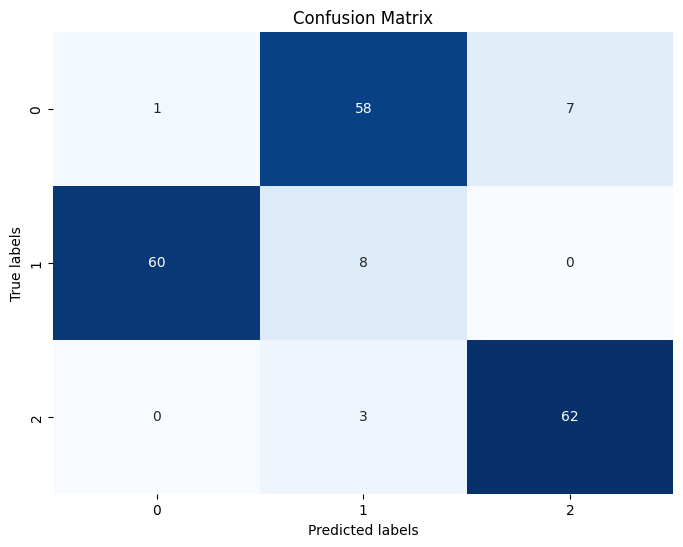

In [138]:
# Extract cluster labels
cluster_labelsFF = np.argmax(u, axis=0)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, cluster_labelsFF, average='weighted')
recall = recall_score(y_true, cluster_labelsFF, average='weighted')
f1 = f1_score(y_true, cluster_labelsFF, average='weighted')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, cluster_labelsFF)

# Print precision, recall, F1-score, and confusion matrix
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()